# **Second Code**

✅ Cell 1: Install Dependencies

In [1]:
# Install specific versions
!pip install pytorch-lightning==2.4.0 pytorch-forecasting==1.4.0 --quiet

✅ Cell 2: Load and Prepare the Data

In [14]:
import pandas as pd
import numpy as np
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("/content/sample_data/dengue data 17-07-2025.csv")  # Change path if needed

# Convert date column
df['week_start_date'] = pd.to_datetime(df['week_start_date'])

# Filter only 'sj' city
# df = df[df['city'] == 'sj'].copy()

# Fill missing values
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

# Extract date features
df['month'] = df['week_start_date'].dt.month
df['day'] = df['week_start_date'].dt.day
df['dayofweek'] = df['week_start_date'].dt.dayofweek
df['year'] = df['week_start_date'].dt.year

# Convert city to categorical code
df['city'] = df['city'].astype('category').cat.codes

# Sort and create continuous time index
df = df.sort_values('week_start_date').reset_index(drop=True)
df['time_idx'] = df.index

/tmp/ipython-input-1371272622.py:11: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['week_start_date'] = pd.to_datetime(df['week_start_date'])
/tmp/ipython-input-1371272622.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/tmp/ipython-input-1371272622.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 29 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   city                                   1456 non-null   int8          
 1   year                                   1456 non-null   int32         
 2   weekofyear                             1456 non-null   int64         
 3   week_start_date                        1456 non-null   datetime64[ns]
 4   ndvi_ne                                1456 non-null   float64       
 5   ndvi_nw                                1456 non-null   float64       
 6   ndvi_se                                1456 non-null   float64       
 7   ndvi_sw                                1456 non-null   float64       
 8   precipitation_amt_mm                   1456 non-null   float64       
 9   reanalysis_air_temp_k                  1456 non-null   float64 

✅ Cell 3: Train/Test Split

In [26]:
# 80/20 split
train_size = int(len(df) * 0.8)
train_df = df.iloc[:train_size].copy()
test_df = df.iloc[train_size:].copy()
train_df["time_idx"]

,time_idx
0,0
1,1
2,2
3,3
4,4
...,...
1159,1159
1160,1160
1161,1161
1162,1162


✅ Cell 4: Prepare TimeSeriesDataSet

In [27]:
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.data.encoders import GroupNormalizer
from pytorch_lightning import seed_everything

seed_everything(42)

# Define features
features = [
    'city', 'year', 'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw',
    'precipitation_amt_mm', 'reanalysis_air_temp_k', 'reanalysis_tdtr_k',
    'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
    'station_min_temp_c', 'station_precip_mm', 'month', 'day', 'dayofweek'
]

target = 'total_cases'
max_encoder_length = 30
max_prediction_length = 10
training_cutoff = train_df["time_idx"].max() - max_prediction_length

# Create training dataset
training = TimeSeriesDataSet(
    train_df,#[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target=target,
    group_ids=["city"],
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    time_varying_known_reals=["time_idx"] + features,
    time_varying_unknown_reals=[target],
    target_normalizer=GroupNormalizer(groups=["city"]),
    allow_missing_timesteps=True
)

validation = TimeSeriesDataSet.from_dataset(training, test_df, stop_randomization=True)


INFO:lightning_fabric.utilities.seed:Seed set to 42


✅ Cell 5: Create DataLoaders

In [29]:
batch_size = 64
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)


✅ Cell 6: Define and Train TFT Model

In [32]:
# ✅ Cell 6: Define and Train TFT Model (consistent Lightning imports)

import lightning.pytorch as L
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_forecasting import TemporalFusionTransformer
from pytorch_forecasting.metrics import QuantileLoss
import torch

# (optional) a tiny perf tweak on CPU
torch.set_float32_matmul_precision("medium")

early_stop = EarlyStopping(monitor="val_loss", patience=5, mode="min")
lr_logger = LearningRateMonitor(logging_interval="epoch")

trainer = L.Trainer(
    max_epochs=30,
    gradient_clip_val=0.1,
    callbacks=[early_stop, lr_logger],
    accelerator="auto",   # will use CPU here (GPU not available)
    devices=1,
)

# Build TFT from the *training dataset*, not the dataloader
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.003,
    hidden_size=64,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=64,
    output_size=7,               # 7 quantiles
    loss=QuantileLoss(),         # required when using quantiles
    log_interval=10,
    reduce_on_plateau_patience=4
)

# Sanity check: should print True
print("Is LightningModule?", isinstance(tft, L.LightningModule))

trainer.fit(
    model=tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Is LightningModule? True


INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 0      | train
3  | prescalers                         | ModuleDict                      | 2.6 K  | train
4  | static_variable_selection          | VariableSelectionNetwork        | 16.9 K | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 346 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 327 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 16.8 K | train
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (19) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

✅ Cell 7: Evaluate the Model

In [33]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_model.predict(val_dataloader)

y_true = actuals.numpy()
y_pred = predictions.numpy()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")


/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


MSE: 269.67
RMSE: 16.42
MAE: 9.26


✅ Cell 8: Plot Actual vs Predicted

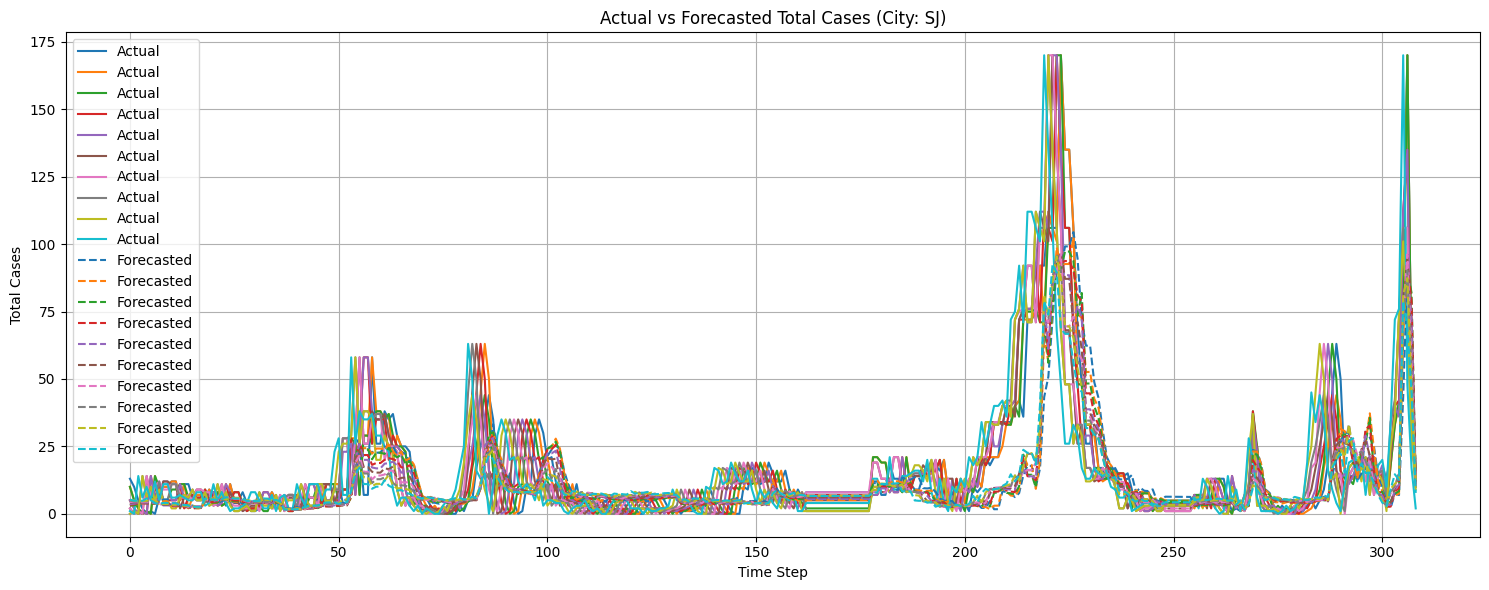

In [34]:
plt.figure(figsize=(15, 6))
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Forecasted', linestyle='--')
plt.title("Actual vs Forecasted Total Cases (City: SJ)")
plt.xlabel("Time Step")
plt.ylabel("Total Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
